In [86]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets, transforms 
import torchvision
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import os
import shutil
from pathlib import Path
import kagglehub

## Get dataloaders with transforms for training

In [88]:
def get_dataloaders(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    
    train_dir = os.path.join(data_dir, 'Training')
    test_dir = os.path.join(data_dir, 'Testing')
    
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    class_names = train_dataset.classes
    
    return train_loader, val_loader, class_names

## Visualisation functions

In [89]:
def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

## CNN class implementation with model architecture

In [90]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # output: 224x224x64
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=0)  # output: 222x222x64
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)  # Output: 111x111x64
        self.dropout1 = nn.Dropout(0.35)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=0)  # output: 109x109x64
        self.bn3 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # output: 54x54x64
        self.dropout2 = nn.Dropout(0.3)
        
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # output: 54x54x64
        self.bn4 = nn.BatchNorm2d(64)
        
        self.dropout3 = nn.Dropout(0.3)
        self.fc = nn.Linear(54 * 54 * 64, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc_out = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # 224x224
        
        x = F.relu(self.conv2(x))  # 222x222
        x = self.pool1(x)          # 111x111
        x = self.bn2(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv3(x))  # 109x109
        x = self.pool2(x)          # 54x54
        x = self.bn3(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn4(self.conv4(x)))  # 54x54

        # flatten
        x = x.view(x.size(0), -1)  # 54*54*64=186624
        
        x = self.dropout3(x)
        x = F.relu(self.bn5(self.fc(x)))
        x = self.fc_out(x)
        
        return x

## Train function

In [91]:
def train_model(data_dir, epochs=30, batch_size=32, lr=0.001, device='cuda'):
    train_loader, val_loader, class_names = get_dataloaders(data_dir, batch_size)
    
    model = BrainTumorCNN(num_classes=len(class_names)).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        print(f"Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        model.eval()
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                val_corrects += torch.sum(preds == labels.data)
        
        val_acc = val_corrects.double() / len(val_loader.dataset)
        history['val_acc'].append(val_acc.item())
        
        print(f"Validation Accuracy: {val_acc:.4f}\n")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print("Best model saved!\n")
    
    print(f"Best validation accuracy: {best_acc:.4f}")
    
    plot_training_history(history)
    
    return model, history


## Evaluation

In [92]:
def evaluate_model(model, data_dir, batch_size=32, device='cuda'):
    _, val_loader, class_names = get_dataloaders(data_dir, batch_size)
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)

## Main flow

### Dataset downloading

In [93]:
data_dir = kagglehub.dataset_download('sartajbhuvaji/brain-tumor-classification-mri')

### Training, evaluation and visualisation

Epoch 1/30: 100%|██████████| 359/359 [00:17<00:00, 20.48it/s]

Train Loss: 0.8518, Accuracy: 0.6721


Validation Accuracy: 0.5051

Best model saved!



Epoch 2/30: 100%|██████████| 359/359 [00:17<00:00, 20.75it/s]

Train Loss: 0.6196, Accuracy: 0.7578


Validation Accuracy: 0.5685

Best model saved!



Epoch 3/30: 100%|██████████| 359/359 [00:17<00:00, 20.74it/s]

Train Loss: 0.4186, Accuracy: 0.8383


Validation Accuracy: 0.6294

Best model saved!



Epoch 4/30: 100%|██████████| 359/359 [00:17<00:00, 20.76it/s]

Train Loss: 0.3354, Accuracy: 0.8725


Validation Accuracy: 0.6218



Epoch 5/30: 100%|██████████| 359/359 [00:17<00:00, 20.77it/s]

Train Loss: 0.2660, Accuracy: 0.9017


Validation Accuracy: 0.6371

Best model saved!



Epoch 6/30: 100%|██████████| 359/359 [00:17<00:00, 20.79it/s]

Train Loss: 0.2327, Accuracy: 0.9167


Validation Accuracy: 0.6954

Best model saved!



Epoch 7/30: 100%|██████████| 359/359 [00:17<00:00, 20.75it/s]

Train Loss: 0.1886, Accuracy: 0.9334


Validation Accuracy: 0.7360

Best model saved!



Epoch 8/30: 100%|██████████| 359/359 [00:17<00:00, 20.75it/s]

Train Loss: 0.1586, Accuracy: 0.9408


Validation Accuracy: 0.7360



Epoch 9/30: 100%|██████████| 359/359 [00:17<00:00, 20.81it/s]

Train Loss: 0.1657, Accuracy: 0.9446


Validation Accuracy: 0.7030



Epoch 10/30: 100%|██████████| 359/359 [00:17<00:00, 20.74it/s]

Train Loss: 0.1110, Accuracy: 0.9589


Validation Accuracy: 0.7437

Best model saved!



Epoch 11/30: 100%|██████████| 359/359 [00:17<00:00, 20.68it/s]

Train Loss: 0.1197, Accuracy: 0.9571


Validation Accuracy: 0.7335



Epoch 12/30: 100%|██████████| 359/359 [00:17<00:00, 20.78it/s]

Train Loss: 0.1254, Accuracy: 0.9624


Validation Accuracy: 0.7563

Best model saved!



Epoch 13/30: 100%|██████████| 359/359 [00:17<00:00, 20.68it/s]

Train Loss: 0.1192, Accuracy: 0.9606


Validation Accuracy: 0.7462



Epoch 14/30: 100%|██████████| 359/359 [00:17<00:00, 20.73it/s]

Train Loss: 0.0887, Accuracy: 0.9697


Validation Accuracy: 0.7589

Best model saved!



Epoch 15/30: 100%|██████████| 359/359 [00:17<00:00, 20.69it/s]

Train Loss: 0.1181, Accuracy: 0.9617


Validation Accuracy: 0.7640

Best model saved!



Epoch 16/30: 100%|██████████| 359/359 [00:17<00:00, 20.76it/s]

Train Loss: 0.0891, Accuracy: 0.9683


Validation Accuracy: 0.7614



Epoch 17/30: 100%|██████████| 359/359 [00:17<00:00, 20.64it/s]

Train Loss: 0.0877, Accuracy: 0.9711


Validation Accuracy: 0.7234



Epoch 18/30: 100%|██████████| 359/359 [00:17<00:00, 20.69it/s]

Train Loss: 0.0856, Accuracy: 0.9700


Validation Accuracy: 0.7462



Epoch 19/30: 100%|██████████| 359/359 [00:17<00:00, 20.67it/s]

Train Loss: 0.0709, Accuracy: 0.9753


Validation Accuracy: 0.7284



Epoch 20/30: 100%|██████████| 359/359 [00:17<00:00, 20.65it/s]

Train Loss: 0.1039, Accuracy: 0.9679


Validation Accuracy: 0.7157



Epoch 21/30: 100%|██████████| 359/359 [00:17<00:00, 20.73it/s]

Train Loss: 0.0758, Accuracy: 0.9742


Validation Accuracy: 0.7335



Epoch 22/30: 100%|██████████| 359/359 [00:17<00:00, 20.66it/s]

Train Loss: 0.1000, Accuracy: 0.9683


Validation Accuracy: 0.7056



Epoch 23/30: 100%|██████████| 359/359 [00:17<00:00, 20.64it/s]

Train Loss: 0.0606, Accuracy: 0.9805


Validation Accuracy: 0.7259



Epoch 24/30: 100%|██████████| 359/359 [00:17<00:00, 20.67it/s]

Train Loss: 0.0423, Accuracy: 0.9871


Validation Accuracy: 0.7335



Epoch 25/30: 100%|██████████| 359/359 [00:17<00:00, 20.65it/s]

Train Loss: 0.0353, Accuracy: 0.9895


Validation Accuracy: 0.7360



Epoch 26/30: 100%|██████████| 359/359 [00:17<00:00, 20.69it/s]

Train Loss: 0.0750, Accuracy: 0.9756


Validation Accuracy: 0.7462



Epoch 27/30: 100%|██████████| 359/359 [00:17<00:00, 20.70it/s]

Train Loss: 0.0865, Accuracy: 0.9753


Validation Accuracy: 0.7513



Epoch 28/30: 100%|██████████| 359/359 [00:17<00:00, 20.67it/s]

Train Loss: 0.0488, Accuracy: 0.9840


Validation Accuracy: 0.7411



Epoch 29/30: 100%|██████████| 359/359 [00:17<00:00, 20.63it/s]

Train Loss: 0.0516, Accuracy: 0.9829


Validation Accuracy: 0.7335



Epoch 30/30: 100%|██████████| 359/359 [00:17<00:00, 20.63it/s]

Train Loss: 0.0660, Accuracy: 0.9787


Validation Accuracy: 0.7716

Best model saved!

Best validation accuracy: 0.7716


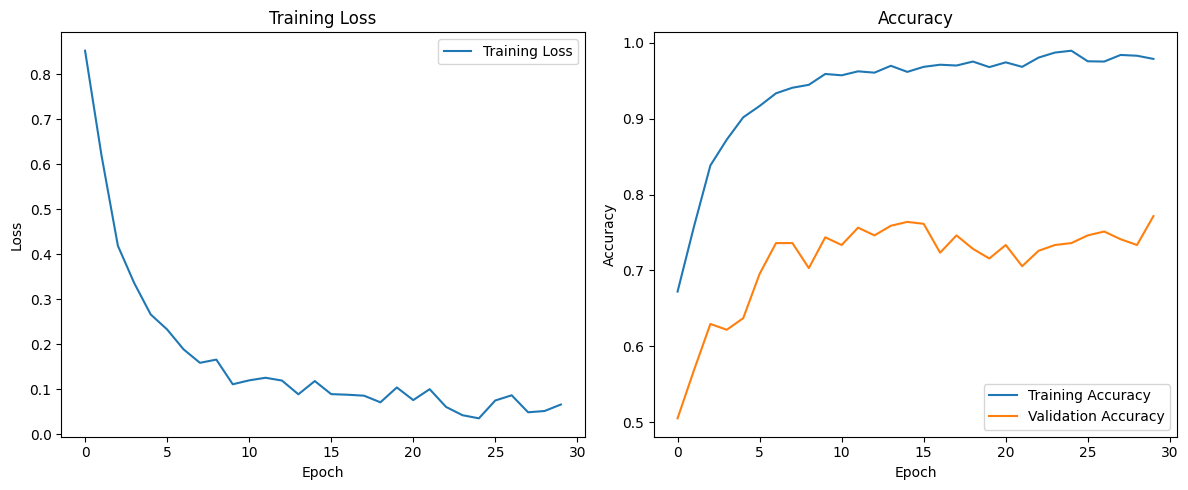

Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.85it/s]


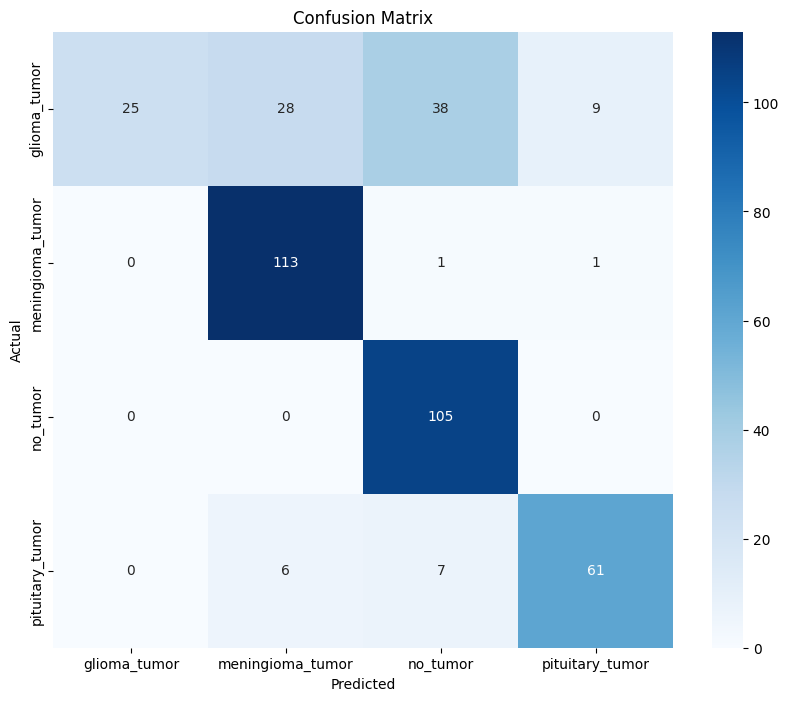

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.25      0.40       100
meningioma_tumor       0.77      0.98      0.86       115
        no_tumor       0.70      1.00      0.82       105
 pituitary_tumor       0.86      0.82      0.84        74

        accuracy                           0.77       394
       macro avg       0.83      0.76      0.73       394
    weighted avg       0.82      0.77      0.73       394



In [97]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, history = train_model(data_dir, epochs=30, batch_size=8, device=device, lr=0.005)
evaluate_model(model, data_dir, device=device)